In [49]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans, KMeansSummary
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.linalg import DenseVector
import numpy as np


In [50]:
spark = SparkSession.builder \
    .appName("Agrupamento K-means") \
    .getOrCreate()


In [51]:
df = spark.read.csv("/user/mallcustomers.csv", header=True, inferSchema=True)

In [52]:
df = df.withColumn("Income", regexp_replace(col("Income"), " USD", ""))
df = df.withColumn("Income", regexp_replace(col("Income"), ",", ".").cast("float"))

In [53]:
print(df)

DataFrame[CustomerID: int, Gender: string, Age: int, Income: float, SpendingScore: int]


In [54]:
df.describe().show()

+-------+------------------+------+-----------------+-----------------+------------------+
|summary|        CustomerID|Gender|              Age|           Income|     SpendingScore|
+-------+------------------+------+-----------------+-----------------+------------------+
|  count|               200|   200|              200|              200|               200|
|   mean|             100.5|  NULL|            38.85|            60.56|              50.2|
| stddev|57.879184513951124|  NULL|13.96900733155888|26.26472116527124|25.823521668370173|
|    min|                 1|Female|               18|             15.0|                 1|
|    max|               200|  Male|               70|            137.0|                99|
+-------+------------------+------+-----------------+-----------------+------------------+



In [55]:
feature_cols = ["Age", "Income", "SpendingScore"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df_standardized = scaler_model.transform(df)

In [56]:
df_standardized.show()

+----------+------+---+------+-------------+----------------+--------------------+
|CustomerID|Gender|Age|Income|SpendingScore|        features|     scaled_features|
+----------+------+---+------+-------------+----------------+--------------------+
|         1|  Male| 19|  15.0|           39|[19.0,15.0,39.0]|[-1.4210029051351...|
|         2|  Male| 21|  15.0|           81|[21.0,15.0,81.0]|[-1.2778288088999...|
|         3|Female| 20|  16.0|            6| [20.0,16.0,6.0]|[-1.3494158570175...|
|         4|Female| 23|  16.0|           77|[23.0,16.0,77.0]|[-1.1346547126646...|
|         5|Female| 31|  17.0|           40|[31.0,17.0,40.0]|[-0.5619583277234...|
|         6|Female| 22|  17.0|           76|[22.0,17.0,76.0]|[-1.2062417607822...|
|         7|Female| 35|  18.0|            6| [35.0,18.0,6.0]|[-0.2756101352529...|
|         8|Female| 23|  18.0|           94|[23.0,18.0,94.0]|[-1.1346547126646...|
|         9|  Male| 64|  19.0|            3| [64.0,19.0,3.0]|[1.80041426015869...|
|   

In [57]:
df_standardized.select("CustomerID", "scaled_features").show(truncate=False)

+----------+--------------------------------------------------------------+
|CustomerID|scaled_features                                               |
+----------+--------------------------------------------------------------+
|1         |[-1.4210029051351947,-1.7346462470822699,-0.43371311410706104]|
|2         |[-1.2778288088999106,-1.7346462470822699,1.1927110637944185]  |
|3         |[-1.3494158570175527,-1.696572361062027,-1.7116178253153662]  |
|4         |[-1.1346547126646265,-1.696572361062027,1.0378135230418966]   |
|5         |[-0.5619583277234902,-1.658498475041784,-0.39498872891893055] |
|6         |[-1.2062417607822686,-1.658498475041784,0.9990891378537661]   |
|7         |[-0.275610135252922,-1.620424589021541,-1.7116178253153662]   |
|8         |[-1.1346547126646265,-1.620424589021541,1.6961280712401143]   |
|9         |[1.8004142601586974,-1.5823507030012982,-1.8277909808797577]  |
|10        |[-0.6335453758411322,-1.5823507030012982,0.8441915971012443]  |
|11        |

In [58]:
wss_values = []
silhouette_values = []
gap_values = []
num_datasets = 10

for k in range(2, 11):
    kmeans = KMeans(featuresCol="scaled_features", k=k, seed=42)
    model = kmeans.fit(df_standardized)
    predictions = model.transform(df_standardized)
    evaluator = ClusteringEvaluator()
    wss_values.append(-evaluator.evaluate(predictions))

    # Calcular Silhouette Score
    silhouette_values.append(evaluator.evaluate(predictions))
    

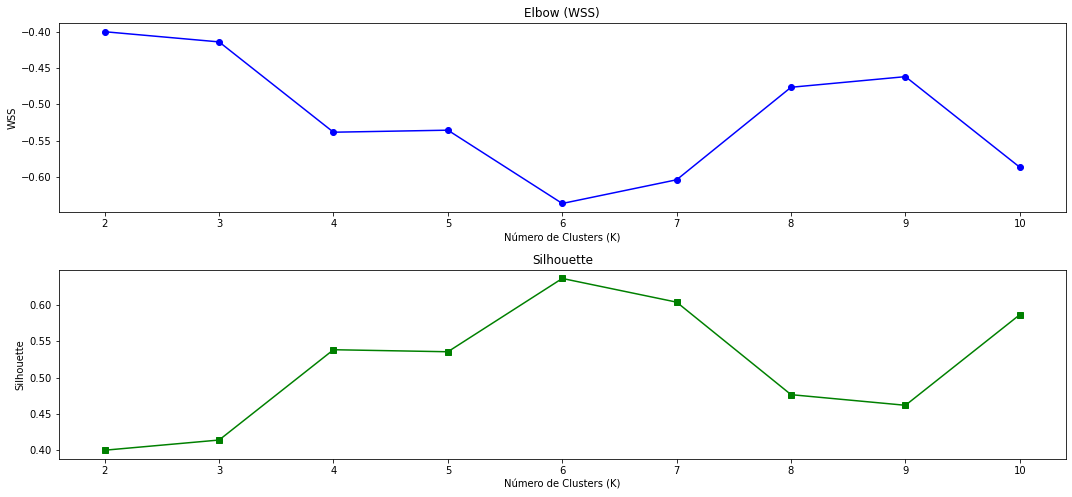

In [59]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(range(2, 11), wss_values, label='WSS', marker='o', color='blue')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('WSS')
plt.title('Elbow (WSS)')

plt.subplot(3, 1, 2)
plt.plot(range(2, 11), silhouette_values, label='Silhouette', marker='s', color='green')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette')
plt.title('Silhouette')

plt.tight_layout()
plt.show()
